In [1]:
import spaudiopy as spa
import pyfar as pf
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import soundfile as sf

Generelle Idee meines Ansatzes:
- Ausgangspunkt: Spherical Harmonics
    - SH mit virtuellen LS decodieren oder
    - SH per Beamforming extrahieren
- Berechnung der Parameter
- Plot
- Profit

In [3]:
# Definition von Variablen 
fs = 44100
# audio,fs = sf.read("HOA\HOA_A10p_S00_R00_CH01.wav")

# Definition der Evaluationszeiträume
tl = 15
tu = 100

tl = round((tl*(10**(-3)))*fs)
tu = round((tu*(10**(-3)))*fs)


# Erstellung der Multifile-IR
RIR_Mf = np.zeros((16,224910))
n = 0

for i in [f'{i:>02}' for i in range(1, 16)]:
    RIR = spa.io.load_audio("HOA\HOA_A10p_S00_R00_CH" + i + ".wav")
    RIR_Mf[n] = spa.sig.MonoSignal(RIR, fs = 48000)
    n = n+1

In [5]:
# Berechnung der Schalleinfallsrichtungen + Energien über LS:

# # Definition des Lautsprechersetups
# ls_setup = spa.decoder.LoudspeakerSetup([1,0,0,0,0,-1], [0,1,0,-1,0,0], [0,0,1,0,-1,0])
# ls_setup.ambisonics_setup()
# ls_setup.ambisonics_hull.show()
# # Decoden des Ambisonics-Signals in Einzelsignale
# ls_sig = spa.decoder.allrad(RIR_Mf, ls_setup, 3)

# # Berechnung der Richtungsenergien
# front = sum(ls_sig[0, tl:tu])
# back = sum(ls_sig[5, tl:tu])
# top = sum(ls_sig[2, tl:tu])
# left = sum(ls_sig[1, tl:tu])
# right = sum(ls_sig[3, tl:tu])

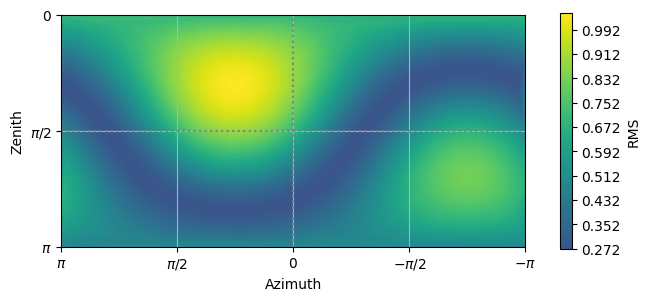

In [4]:
# Berechnung der Schalleinfallsrichtungen + Energien über Beamforming:

# Definieren des Beamformers in Nierenform (top, links, rechts, hinten)
beam_def = spa.parsa.sh_beamformer_from_pattern('cardioid', 3, [0,1.5*np.pi,0.5*np.pi, np.pi], [0.5*np.pi, 0, 0, 0])
beam_sig = spa.parsa.sh_beamform(beam_def,RIR_Mf)
spa.plot.sh_rms_map(beam_def) # (!!)stimmt noch nicht(!!)

# (evtl. eher sph.design_sph_filterbank() nutzen und mit sph.sph_filterbank_reconstruction_factor() korrigieren)

# Berechnung der Richtungsenergien
# front = sum(beam_sig[4, tl:tu])
back = sum(beam_sig[3, tl:tu])
top = sum(beam_sig[0, tl:tu])
left = sum(beam_sig[1, tl:tu])
right = sum(beam_sig[2, tl:tu])

## was ist mit spa.sph.inverse_sht()???


In [20]:
# Berechnung der Schalleinfallsrichtungen über Pseudointensität (IRIS)
ambi_b = spa.sph.sh_to_b(RIR_Mf[0:4])
vek_azi, vek_zen, vek_r = spa.parsa.pseudo_intensity(ambi_b, f_bp = None)

# bzw. über SDM



________________________________________________________________________________
[Memory] Calling spaudiopy.parsa.pseudo_intensity...
pseudo_intensity(array([[ 0.000000e+00, ..., -4.225859e-07],
       ...,
       [ 0.000000e+00, ...,  0.000000e+00]]), f_bp=None)


AttributeError: 'numpy.ndarray' object has no attribute 'fs'

In [24]:
# Beschreibung des Parameters

# TS - Top/Sides(left,right)

TS = 10*np.log10((top)**2/(left + right)**2)
print('TS = ' + str(TS))

# TH - Top/Hull(left,right,back)

TH = 10*np.log10((top)**2/(left + right + back)**2)
print('TS = ' + str(TH))


TS = -12.710215849630405
TS = -16.23204103074403


(-1.0, 1.0)

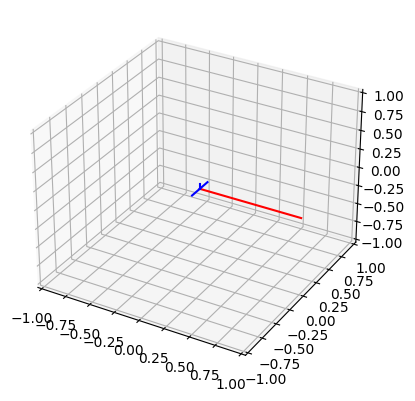

In [25]:

# Darstellung des Parameters

# Vorläufiger Plot der reinen IR
# spa.plot.sh_rms_map(RIR_Mf, title="Raw Spatial Impulse Response (with SH)")

ax = plt.axes(projection='3d')
ax.plot3D([0,1],[0,0],[0,0],'red')
# ax.plot3D([1],[1],[1])
ax.plot3D([0,0],[0,0],[0,top],'blue')
ax.plot3D([0,0],[0,left],[0,0],'blue')
ax.plot3D([0,0],[0,-right],[0,0],'blue')

ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-1, top=1)